In [22]:
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
from config import DUCKDB_PATH

# global duckdb connection
con = duckdb.connect(DUCKDB_PATH)
AGG_COLUMNS = [
    'eth_type',
    'ip_src',
    'ip_dst',
]

# print number of attacks and non-attacks
sql = """
    SELECT * FROM bots_agg
"""
bots_data = con.execute(sql).df()

bots_data

,attack_type,date_minutes,avg_frame_time_delta,avg_frame_len,avg_tcp_hdr_len,stddev_frame_time_delta,stddev_frame_len,stddev_tcp_hdr_len,mode_frame_time_delta,mode_frame_len,...,count_tcp_flags_ece,count_tcp_flags_cwr,count_tcp_flags_ae,count_tcp_flags_res,max_frame_time_delta,max_frame_len,max_tcp_hdr_len,min_frame_time_delta,min_frame_len,min_tcp_hdr_len
0,0,2018-03-02 04:52,0.077753,631.918027,21.282156,0.523921,728.644605,4.838407,0.000001,1514,...,296432,296432,296432,296432,60.997557,50098,56,0.0,42,20
1,0,2018-03-02 05:00,0.083315,583.481243,21.189045,0.579728,687.260040,4.156950,0.000001,1514,...,271549,271549,271549,271549,39.199853,14654,56,0.0,42,20
2,0,2018-03-02 05:05,0.135258,397.667311,21.293500,0.639977,598.748796,3.848870,0.000001,54,...,166160,166160,166160,166160,35.296840,6056,56,0.0,42,20
3,0,2018-03-02 05:20,0.167356,249.519858,21.696172,0.756111,425.617233,4.179502,0.000001,54,...,132121,132121,132121,132121,40.438594,10500,48,0.0,42,20
4,0,2018-03-02 05:29,0.154967,302.926551,21.549875,0.744105,490.650739,4.022968,0.000001,54,...,146577,146577,146577,146577,130.365526,14654,48,0.0,42,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2152,0,2018-02-27 22:54,0.063826,172.346809,21.188375,0.091075,250.579301,3.586378,0.000027,54,...,929,929,929,929,0.811272,1229,32,0.0,42,20
2153,0,2018-02-27 22:56,0.064547,179.399146,21.127546,0.086956,262.559022,3.473663,0.000030,54,...,933,933,933,933,0.811226,1229,32,0.0,42,20
2154,0,2018-02-27 23:00,0.050051,178.185833,21.107950,0.063604,261.603893,3.547839,0.000029,54,...,1195,1195,1195,1195,0.432643,1229,40,0.0,42,20
2155,0,2018-02-27 23:10,0.045054,180.382022,21.173815,0.066831,260.776316,3.545833,0.000020,54,...,1329,1329,1329,1329,0.624041,1229,32,0.0,42,20


In [24]:
# print number of attacks and non-attacks
con = duckdb.connect(DUCKDB_PATH)
sql = """
    SELECT COUNT(*) AS num_attacks, attack_type
    FROM bots_agg
    GROUP BY attack_type
"""

result = con.execute(sql).df()

result

,num_attacks,attack_type
0,1815,0
1,342,1


<Figure size 500x300 with 0 Axes>

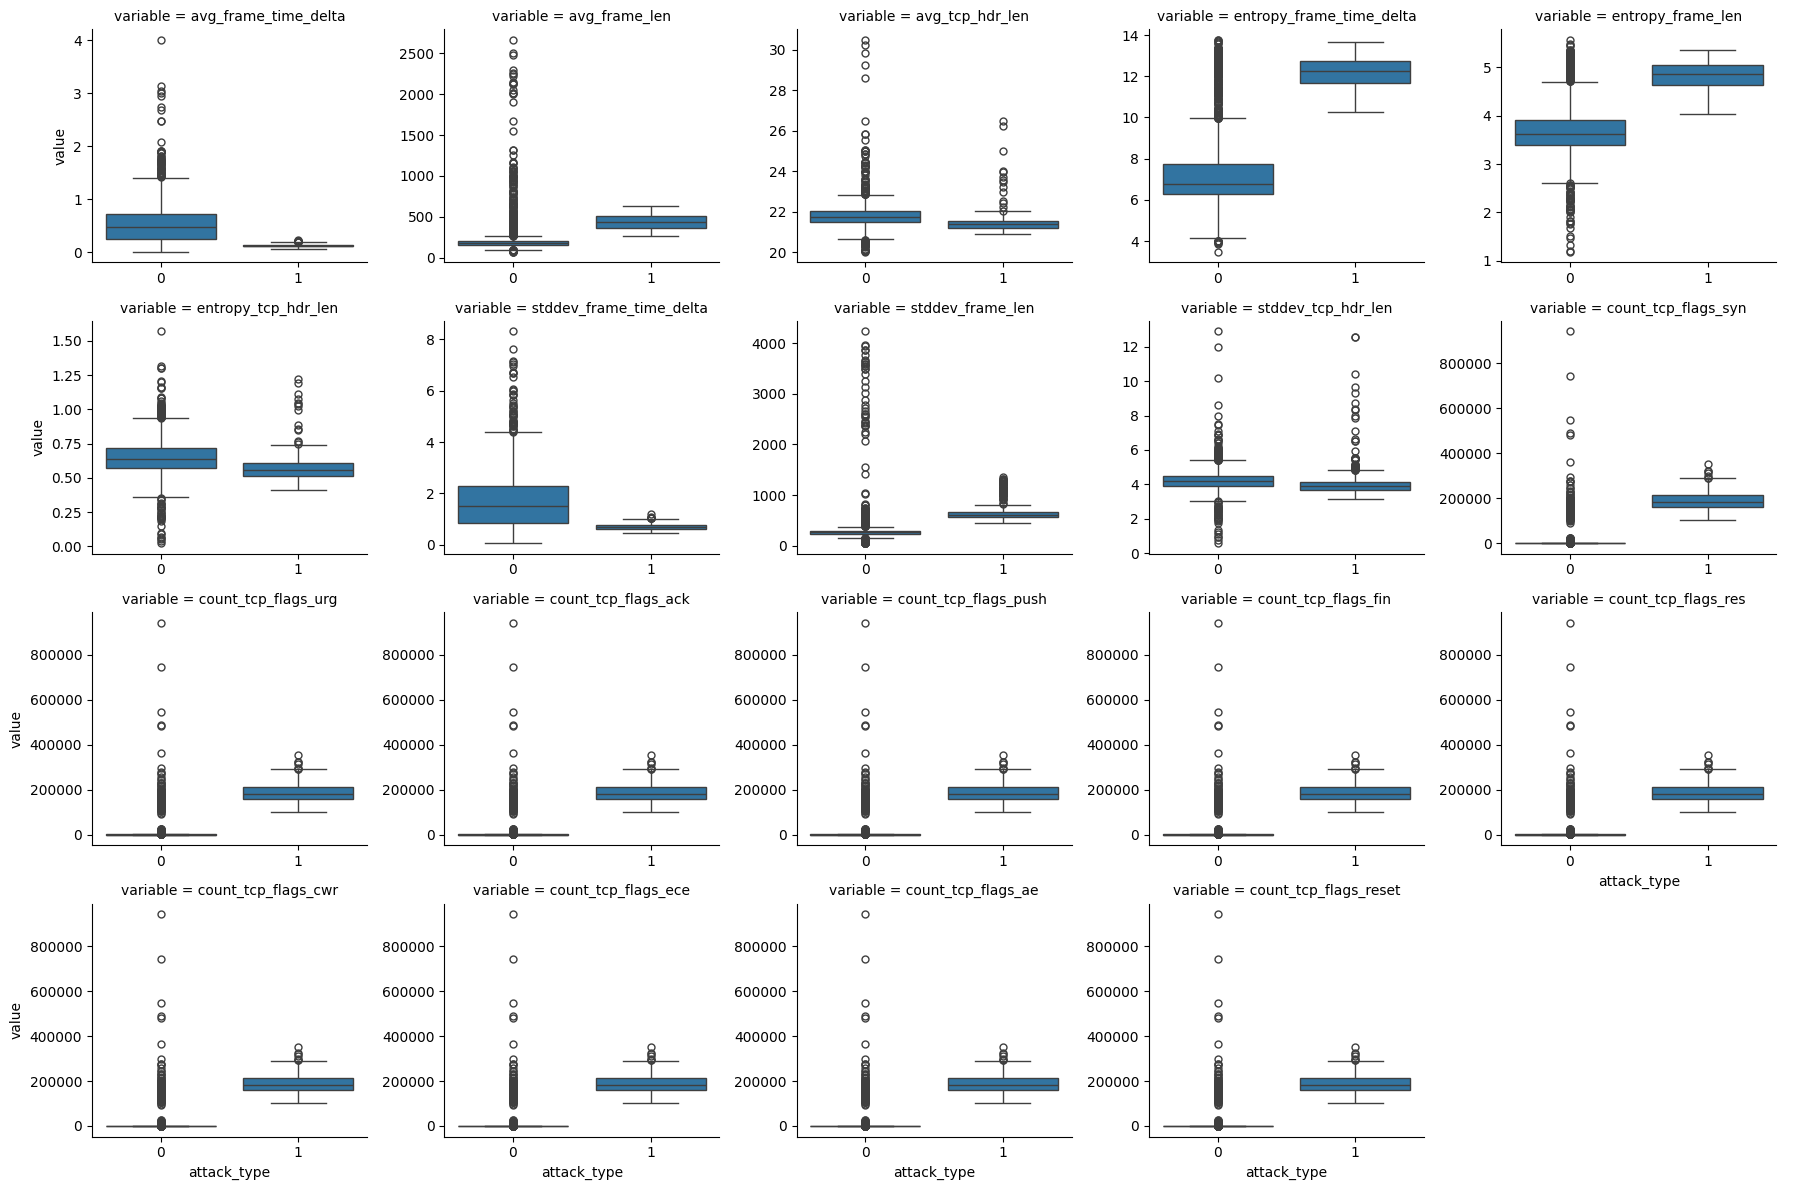

In [36]:
# look at some different features

plt.figure(figsize=(5, 3))
# pivot columns to longer format
bots_data_melt = bots_data.melt(id_vars=['date_minutes', 'attack_type'], value_vars=[
    'avg_frame_time_delta',
    'avg_frame_len',
    'avg_tcp_hdr_len',
    'entropy_frame_time_delta',
    'entropy_frame_len',
    'entropy_tcp_hdr_len',
    
    'stddev_frame_time_delta',
    'stddev_frame_len',
    'stddev_tcp_hdr_len',
    
    'count_tcp_flags_syn',
    'count_tcp_flags_urg',
    'count_tcp_flags_ack',
    'count_tcp_flags_push',
    'count_tcp_flags_fin',
    'count_tcp_flags_res',
    'count_tcp_flags_cwr',
    'count_tcp_flags_ece',
    'count_tcp_flags_ae',
    'count_tcp_flags_reset'
])

sns.catplot(
    data=bots_data_melt,
    x='attack_type',
    y='value',
    kind='box',
    col='variable',
    col_wrap=5,
    sharey=False,
    sharex=False,
    height=3,
    aspect=1.2,
    margin_titles=True,
)